In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
#Step 2: Load Dataset
df = pd.read_csv("sales_dataset_large.csv", parse_dates=["Date"])
df = df.sort_values("Date")
df.head()

OrderID                Date Region  Country      City  ProductCategory  \
0        1 2023-01-01 00:00:00   East    India    Berlin           Sports   
1        2 2023-01-01 01:00:00   West  Germany   Toronto         Clothing   
2        3 2023-01-01 02:00:00  North      USA    Berlin      Electronics   
3        4 2023-01-01 03:00:00   East      USA  New York           Sports   
4        5 2023-01-01 04:00:00   East    India    Mumbai  Home Appliances   

   Product  CustomerID  CustomerAge CustomerGender SalesChannel PaymentMethod  \
0  T-shirt        9955           25         Female      Offline    Debit Card   
1   Camera       41919           68         Female       Online          Cash   
2  T-shirt       23325           42         Female      Offline   Credit Card   
3  T-shirt       46992           28           Male       Online           UPI   
4   Laptop        2702           45         Female      Offline          Cash   

   Quantity  UnitPrice  Discount  Sales          Cost        Profit  
0         5       4646        15  23230  15021.621214   8208.378786  
1         9       3417        20  30753  21657.337151   9095.662849  
2         9       2885        15  25965  22582.762498   3382.237502  
3         4        695        25   2780   2108.175615    671.824385  
4         9       4633         5  41697  26947.079049  14749.920951

In [20]:
date_table = pd.read_csv("date_table.csv")

In [24]:
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
df.describe()

OrderID     CustomerID    CustomerAge       Quantity  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean    50000.500000   25511.685000      43.530710       4.998000   
std     28867.657797   14149.311938      14.986473       2.581252   
min         1.000000    1000.000000      18.000000       1.000000   
25%     25000.750000   13257.000000      31.000000       3.000000   
50%     50000.500000   25516.500000      44.000000       5.000000   
75%     75000.250000   37783.250000      56.000000       7.000000   
max    100000.000000   49998.000000      69.000000       9.000000   

           UnitPrice       Discount          Sales           Cost  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean     2542.706790      15.026000   12709.654950    9529.380054   
std      1411.034139      10.001241   10306.252255    7846.536377   
min       100.000000       0.000000     101.000000      62.428873   
25%      1321.000000       5.000000    4206.000000    3115.041128   
50%      2542.000000      15.000000    9760.000000    7316.885004   
75%      3761.000000      25.000000   18996.000000   14163.814309   
max      4999.000000      30.000000   44991.000000   40393.040248   

              Profit  
count  100000.000000  
mean     3180.274896  
std      2948.669518  
min        12.612824  
25%       952.235733  
50%      2248.493118  
75%      4529.986130  
max     17753.351393

In [25]:
# Step 3: Preprocessing
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day'] = df['Date'].dt.day
df['Hour'] = df['Date'].dt.hour
df['Minute'] = df['Date'].dt.minute


In [27]:
sales_month = df.groupby(df['Date'].dt.to_period("M"))['Sales'].sum().reset_index()
sales_month['Date'] = sales_month['Date'].dt.to_timestamp()
sales_month['Growth'] = sales_month['Sales'].pct_change() * 100
sales_growth = sales_month['Growth'].iloc[-1]  # latest growth %

In [5]:
total_sales = df['Sales'].sum()


In [6]:
total_profit = df['Profit'].sum()


In [7]:
profit_margin = (total_profit / total_sales) * 100


In [8]:
aov = df['Sales'].mean()


In [9]:
repeat_customers = df['CustomerID'].value_counts()[df['CustomerID'].value_counts() > 1].count()
total_customers = df['CustomerID'].nunique()
retention_rate = (repeat_customers / total_customers) * 100
monthly_sales = df.groupby('Month')['Sales'].sum()
sales_growth = ((monthly_sales.iloc[-1] - monthly_sales.iloc[-2]) / monthly_sales.iloc[-2]) * 100



In [10]:
print('Total Sales Revenue:', total_sales)
print('Total Profit:', total_profit)
print('Profit Margin (%):', round(profit_margin,2))
print('Average Order Value:', round(aov,2))
print('Customer Retention Rate (%):', round(retention_rate,2))
print('Sales Growth (%):', round(sales_growth,2))

Total Sales Revenue: 1270965495
Total Profit: 318027489.6402446
Profit Margin (%): 25.02
Average Order Value: 12709.65
Customer Retention Rate (%): 69.41
Sales Growth (%): 4.63


In [11]:
df.head()

OrderID                Date Region  Country      City  ProductCategory  \
0        1 2023-01-01 00:00:00   East    India    Berlin           Sports   
1        2 2023-01-01 01:00:00   West  Germany   Toronto         Clothing   
2        3 2023-01-01 02:00:00  North      USA    Berlin      Electronics   
3        4 2023-01-01 03:00:00   East      USA  New York           Sports   
4        5 2023-01-01 04:00:00   East    India    Mumbai  Home Appliances   

   Product  CustomerID  CustomerAge CustomerGender  ... UnitPrice Discount  \
0  T-shirt        9955           25         Female  ...      4646       15   
1   Camera       41919           68         Female  ...      3417       20   
2  T-shirt       23325           42         Female  ...      2885       15   
3  T-shirt       46992           28           Male  ...       695       25   
4   Laptop        2702           45         Female  ...      4633        5   

   Sales          Cost        Profit  Month  Year  Day  Hour  Minute  
0  23230  15021.621214   8208.378786      1  2023    1     0       0  
1  30753  21657.337151   9095.662849      1  2023    1     1       0  
2  25965  22582.762498   3382.237502      1  2023    1     2       0  
3   2780   2108.175615    671.824385      1  2023    1     3       0  
4  41697  26947.079049  14749.920951      1  2023    1     4       0  

[5 rows x 23 columns]

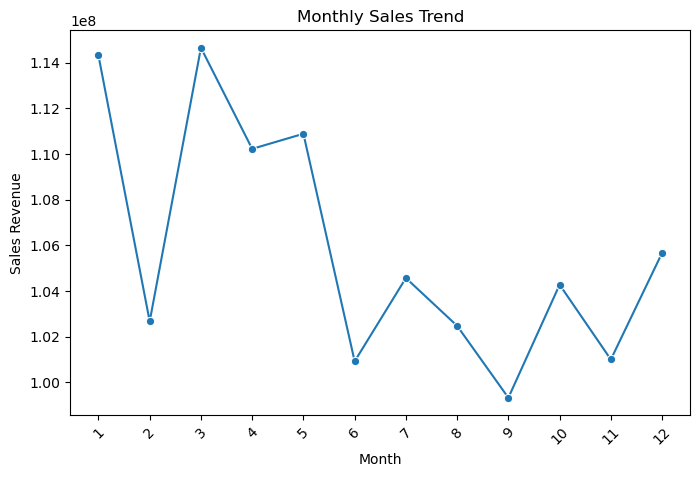

In [12]:
# ---- Visualization: Sales Trend ----
plt.figure(figsize=(8,5))
sns.lineplot(x=monthly_sales.index.astype(str), y=monthly_sales.values, marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Sales Revenue')
plt.xticks(rotation=45)
plt.show()

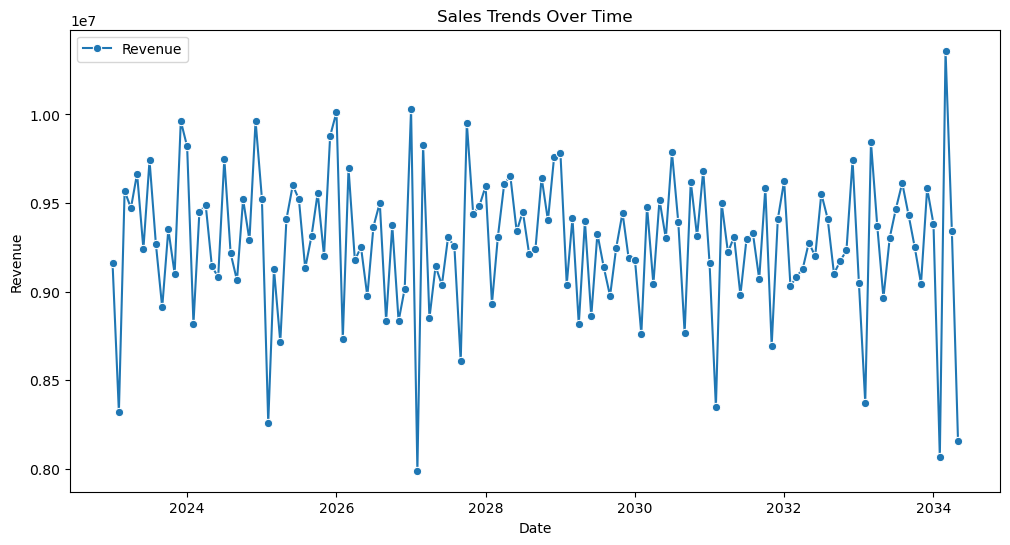

In [29]:
# 1. Sales Trends Over Time
plt.figure(figsize=(12,6))
sns.lineplot(data=sales_month, x="Date", y="Sales", marker="o", label="Revenue")
plt.title("Sales Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.show()




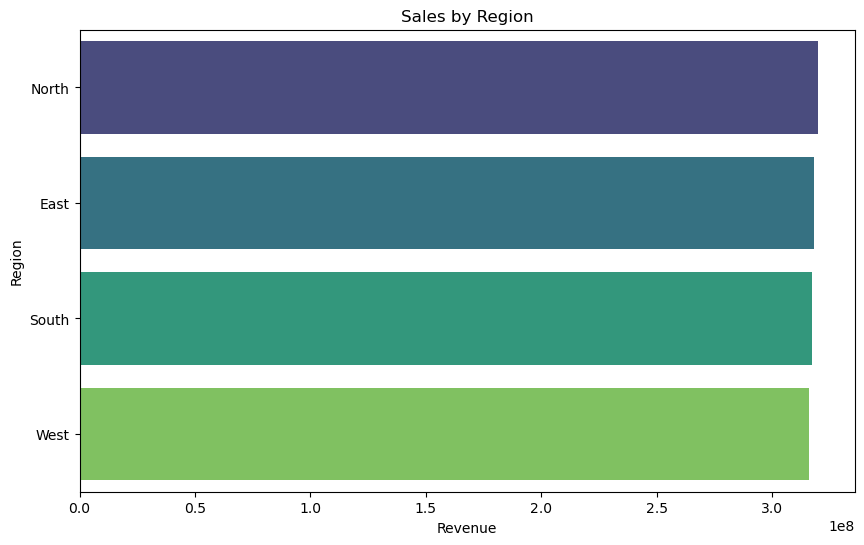

In [31]:
# 2. Sales by Region
plt.figure(figsize=(10,6))
region_sales = df.groupby("Region")['Sales'].sum().sort_values(ascending=False)
sns.barplot(x=region_sales.values, y=region_sales.index, palette="viridis")
plt.title("Sales by Region")
plt.xlabel("Revenue")
plt.show()


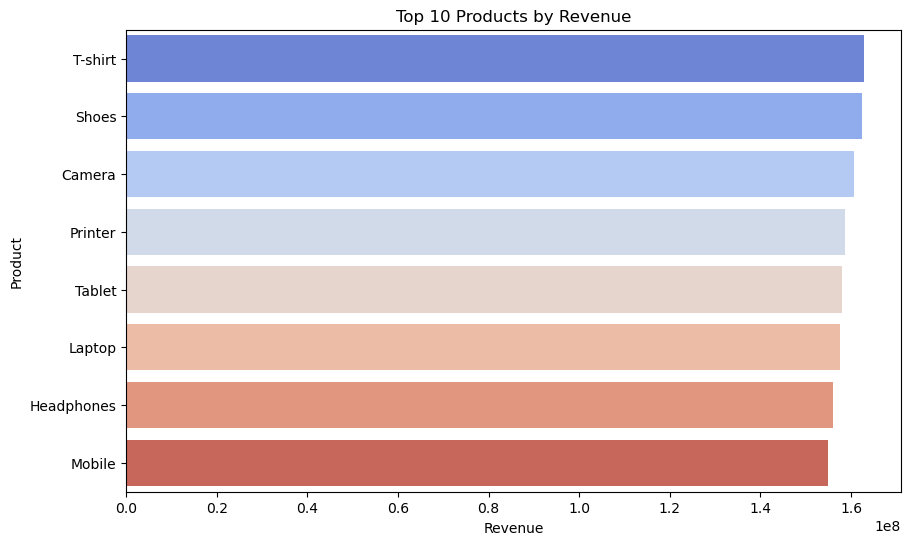

In [32]:
# 3. Top Products
plt.figure(figsize=(10,6))
top_products = df.groupby("Product")['Sales'].sum().nlargest(10)
sns.barplot(x=top_products.values, y=top_products.index, palette="coolwarm")
plt.title("Top 10 Products by Revenue")
plt.xlabel("Revenue")
plt.show()

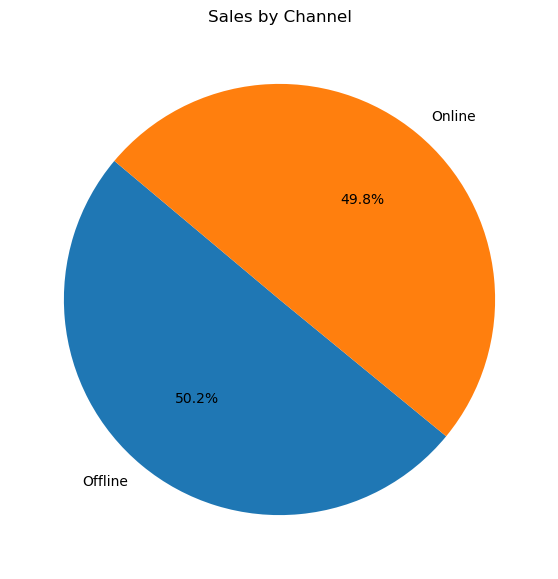

In [36]:
# 4. Sales by Channel
plt.figure(figsize=(7,7))
channel_sales = df.groupby("SalesChannel")['Sales'].sum()
plt.pie(channel_sales, labels=channel_sales.index, autopct='%1.1f%%', startangle=140)
plt.title("Sales by Channel")
plt.show()

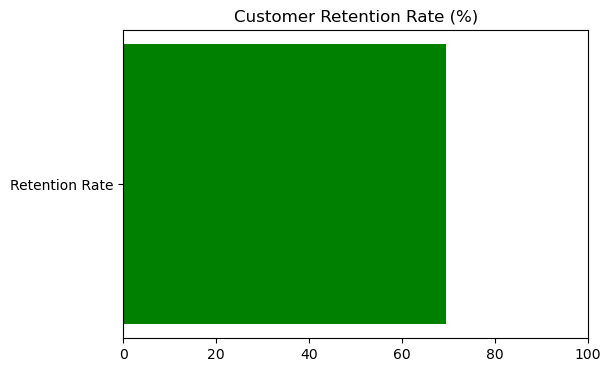

In [37]:
# 5. Customer Metrics (Gauge Style Approx)
plt.figure(figsize=(6,4))
plt.barh(["Retention Rate"], [retention_rate], color="green")
plt.xlim(0,100)
plt.title("Customer Retention Rate (%)")
plt.show()


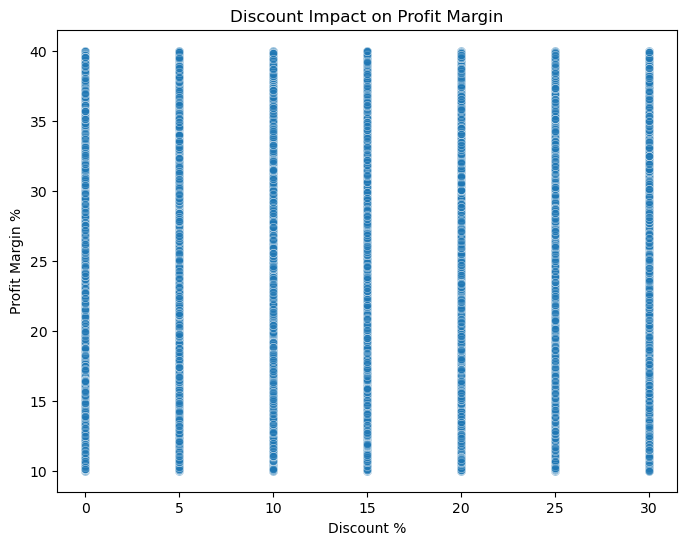

In [40]:
# 6. Discount Impact (Discount vs Profit Margin)
plt.figure(figsize=(8,6))
df['ProfitMargin'] = (df['Sales'] - df['Cost']) / df['Sales'] * 100
sns.scatterplot(data=df, x="Discount", y="ProfitMargin", alpha=0.5)
plt.title("Discount Impact on Profit Margin")
plt.xlabel("Discount %")
plt.ylabel("Profit Margin %")
plt.show()

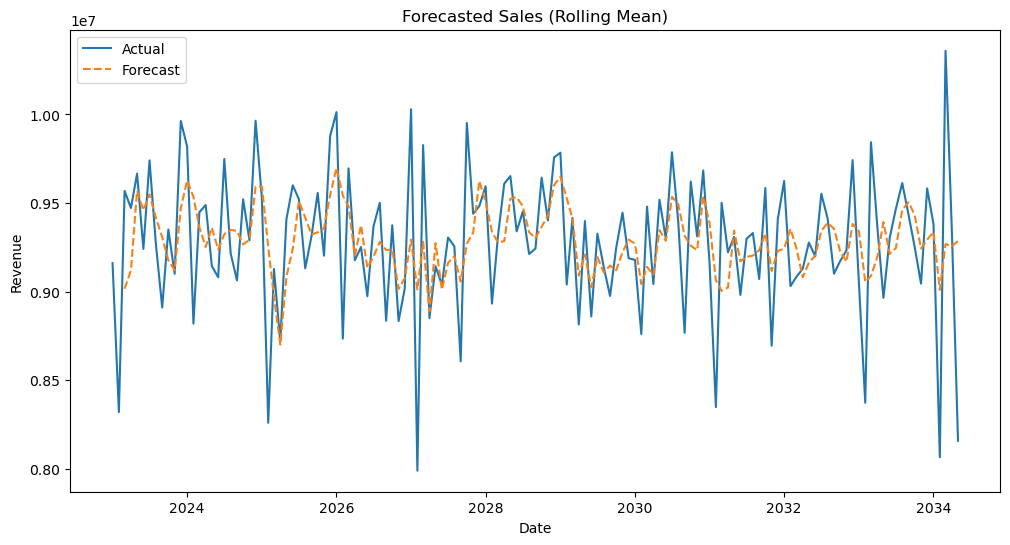

In [41]:
# Forecasted Sales (Simple rolling mean as placeholder)
sales_month['Forecast'] = sales_month['Sales'].rolling(3).mean()

plt.figure(figsize=(12,6))
plt.plot(sales_month['Date'], sales_month['Sales'], label="Actual")
plt.plot(sales_month['Date'], sales_month['Forecast'], label="Forecast", linestyle="--")
plt.title("Forecasted Sales (Rolling Mean)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.show()

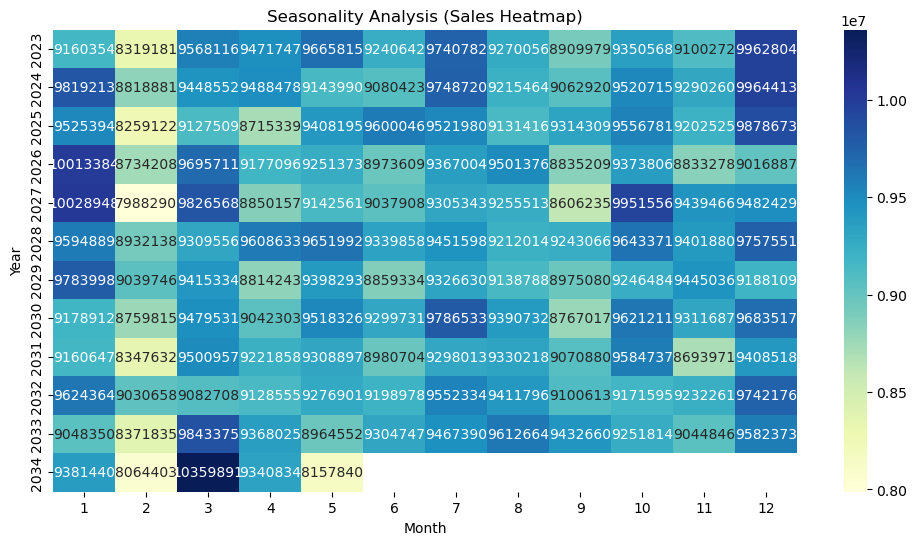

In [43]:
# Seasonality Analysis (Heatmap)
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
seasonality = df.pivot_table(values="Sales", index="Year", columns="Month", aggfunc="sum")

plt.figure(figsize=(12,6))
sns.heatmap(seasonality, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Seasonality Analysis (Sales Heatmap)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()

In [44]:
 #Feature engineering: Lag values
df['Sales_Lag1'] = df['Sales'].shift(1)
df['Sales_Lag7'] = df['Sales'].shift(7)
df['Sales_Rolling_Mean'] = df['Sales'].shift(1).rolling(window=7).mean()
df = df.dropna()

In [45]:
# 3. Train-Test Split
X = df[['Month','Year','Day','Sales_Lag1','Sales_Lag7','Sales_Rolling_Mean']]
y = df['Sales']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [47]:
# 4. Train XGBoost Model
model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [48]:
# 5. Predictions
y_pred = model.predict(X_test)

In [49]:
# 6. Calculate Residual Standard Deviation (for confidence intervals)
residuals = y_test - y_pred
residual_std = residuals.std()

In [50]:
# 6. Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape*100:.2f}%")

RMSE: 10417.05
MAPE: 262.36%


In [51]:
# 7. Visualization (Weekly Aggregated for clarity)
df_plot = df.iloc[-len(y_test):].copy()
df_plot["Week"] = df_plot["Date"].dt.to_period("W").apply(lambda r: r.start_time)

In [52]:
y_test_weekly = y_test.groupby(df_plot["Week"]).mean()
y_pred_weekly = pd.Series(y_pred, index=df_plot["Week"]).groupby(level=0).mean()


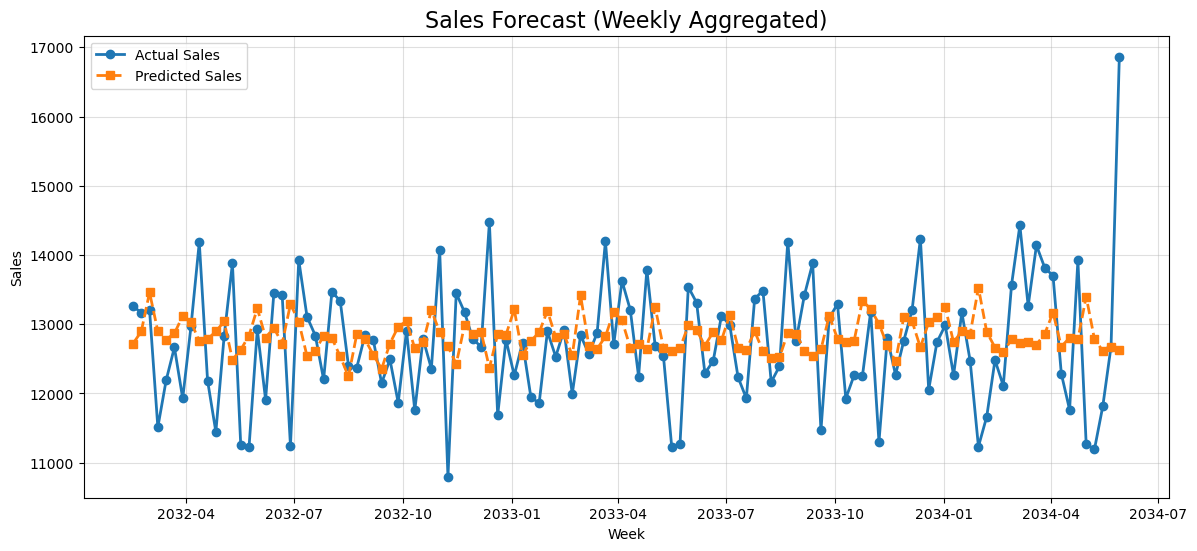

In [25]:
plt.figure(figsize=(14,6))
plt.plot(y_test_weekly.index, y_test_weekly, label="Actual Sales", marker="o", linewidth=2)
plt.plot(y_pred_weekly.index, y_pred_weekly, label="Predicted Sales", marker="s", linestyle="--", linewidth=2)
plt.title("Sales Forecast (Weekly Aggregated)", fontsize=16)
plt.xlabel("Week")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()




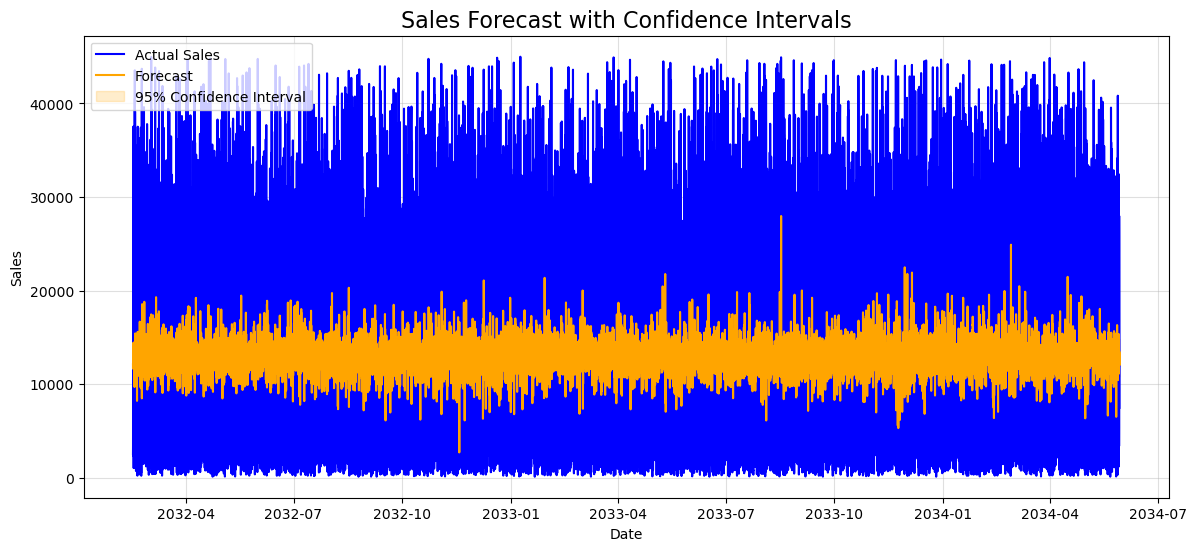

In [53]:
# Example: Add ±10% as confidence interval
upper = y_pred * 1.1
lower = y_pred * 0.9


plt.figure(figsize=(14,6))
plt.plot(df['Date'].iloc[-len(y_test):], y_test, label="Actual Sales", color="blue")
plt.plot(df['Date'].iloc[-len(y_test):], y_pred, label="Forecast", color="orange")
plt.fill_between(df['Date'].iloc[-len(y_test):], lower, upper, 
                 color="orange", alpha=0.2, label="95% Confidence Interval")
plt.title("Sales Forecast with Confidence Intervals", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()